# Belief Propagation Examples (Loopy Graph)

This notebook shows how all currently supported Belief Propagation Solvers can be used out of the box for a toy scenario on a loopy graph.

In the case of a loopy, the messages are initialized and updated iteratively before solving for the beliefs. This is an approximate method that tends to be effective in practice.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import torch_bp.bp as bp
import torch_bp.graph.factors as factors
import torch_bp.distributions as dist
from torch_bp.graph.mrf_graph import MRFGraph
from torch_bp.graph.factor_graph import FactorGraph
from torch_bp.inference.kernels import RBFMedianKernel

from torch_bp.util.plotting import plot_graph, plot_dists, plot_particles

/Users/vd20433/FARSCOPE/MARL/GBP/vectorised-torch-bp/src/torch_bp/bp/linear_gbp.py:225: SyntaxWarning: invalid escape sequence '\ '
  """


|This is the same problem as in the Tree BP notebook, but we add loops to the graph.

In [3]:
N = 9                # Number of agents
SIGMA = 0.05         # Standard deviation for the node observations.
PAIR_ALPHA = 1       # Coefficient for the pairwise factor.
LIMS = [0, 4, 0, 4]  # Limits of the scene.

edges = [(0, 1), (1, 2),
         (0, 3), (1, 4), (2, 5),
         (3, 4), (4, 5),
         (3, 6), (4, 7), (5, 8),
         (6, 7), (7, 8)]

# Define the true node positions and the observations for each node.
node_pos = np.array([[j, i] for i in range(1, 4) for j in range(1, 4)])
node_obs = [dist.Gaussian(node_pos[i, :], SIGMA * torch.eye(2)) for i in range(N)]
node_obs[4] = dist.SmoothUniform([0, 0], [4, 4])  # The middle has no observation.

# Define the unary and pairwise factors.
unary_factors = [factors.DistributionUnaryFactor(node_obs[i]) for i in range(N)]
edge_factor = factors.DistancePairwiseFactor(1, alpha=PAIR_ALPHA)  # Since the edge factors are the same, we can define it once.

# Construct the graph.
mrf_graph = MRFGraph(N, edges, unary_factors=unary_factors, edge_factors=edge_factor)

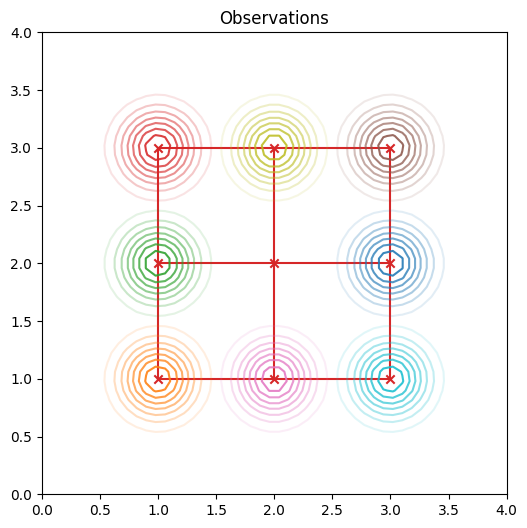

In [4]:
# Visualize.
fig, ax = plt.subplots(figsize=(6, 6))
plt.title("Observations")
plot_graph(ax, node_pos, mrf_graph)
plot_dists(ax, node_obs, LIMS)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## Loopy Stein Variational Belief Propagation

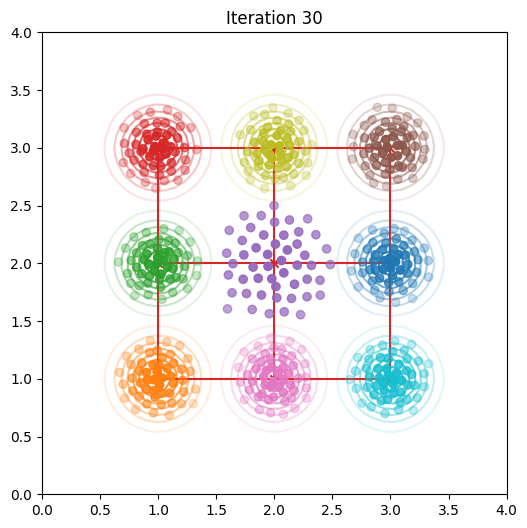

In [5]:
K = 50            # num of particles per node
INIT_SIGMA = 0.1  # spread of initial particles

ITER = 30              # number of iteration to make particles converge
MSG_PASS_PER_ITER = 5  # number of message passing cycles per iteration

rbf_kernel = RBFMedianKernel(sigma=0.05)  # kernel to use
optim_type = torch.optim.Adam             # optimizer type
optim_hyperparams = {'lr': 0.1}           # optimizer params

sig = INIT_SIGMA * torch.eye(2, dtype=torch.float32)
init_particles = torch.stack([dist.Gaussian(node_pos[i, :], sig).sample(K) for i in range(N)])

loopy_sbp = bp.LoopySVBP(particles=init_particles, graph=mrf_graph,
                         kernel=rbf_kernel,
                         optim_type=optim_type, optim_kwargs=optim_hyperparams,
                         msg_init_mode="uniform")
particles, weights = loopy_sbp.solve(num_iters=ITER, msg_pass_per_iter=MSG_PASS_PER_ITER, return_weights=True)

# Draw the final particles
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Iteration {ITER}")
plot_particles(ax, particles, node_pos=node_pos, graph=mrf_graph, dists=node_obs, weights=weights, lims=LIMS)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## Loopy Particle Belief Propagation

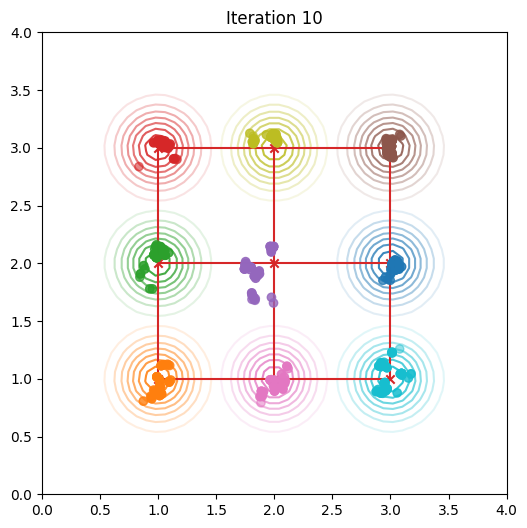

In [6]:
K = 50            # num of particles per node
INIT_SIGMA = 0.1  # spread of initial particles

ITER = 10              # number of iteration to make particles converge
MSG_PASS_PER_ITER = 5  # number of message passing cycles per iteration
JITTER = 0.01          # To jitter particles between iterations

sig = INIT_SIGMA * torch.eye(2, dtype=torch.float32)
init_particles = torch.stack([dist.Gaussian(node_pos[i, :], sig).sample(K) for i in range(N)])

loopy_pbp = bp.LoopyParticleBP(init_particles=init_particles, graph=mrf_graph,
                               msg_init_mode="uniform")
particles, weights = loopy_pbp.solve(num_iters=ITER, msg_pass_per_iter=MSG_PASS_PER_ITER,
                                     jitter_sigma=JITTER, return_weights=True)

# Draw the particles
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Iteration {ITER}")
plot_particles(ax, particles, node_pos=node_pos, graph=mrf_graph, dists=node_obs, weights=weights, lims=LIMS)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## Loopy Gaussian Belief Propagation

In [7]:
from torch_bp.graph.factors.linear_gaussian_factors import UnaryGaussianLinearFactor, PairwiseGaussianLinearFactor
N = 9                # Number of agents
SIGMA = 0.05         # observation variance
tensor_kwargs={'device': 'cpu', 'dtype': torch.float64}  # default uses float64 due to inversion ops
batch_dim = 3        # Number of vectorised instances

# updated graph
nodes = [(i,) for i in range(N)]
# Add some small perturbations to the node positions across the batch dimensions to prove batched computation is working.
batched_node_pos = torch.tensor(np.array([
    np.array([[j + np.random.uniform(-0.25, 0.25), i + np.random.uniform(-0.25, 0.25)] for i in range(1, 4) for j in range(1, 4)])
    for _ in range(batch_dim)
]), **tensor_kwargs)

batched_node_obs = [
    [dist.Gaussian(batched_node_pos[:, i, :], SIGMA * torch.eye(2).repeat(batch_dim, 1, 1)) for i in range(N)]
    for _ in range(batch_dim)
]

edges = [(0, 1), (1, 2),
         (0, 3), (1, 4), (2, 5),
         (3, 4), (4, 5),
         (3, 6), (4, 7), (5, 8),
         (6, 7), (7, 8)]


def unary_anchor_fn(x: torch.Tensor):
    batch_dim = x.shape[:1]
    grad = torch.eye(x.shape[-1], dtype=x.dtype).repeat(batch_dim + (1, 1)) # shape: [batch_dim, x_dim, x_dim]
    return grad, x 
def pairwise_dist_fn(x: torch.Tensor):
    h_fn = lambda x: torch.linalg.norm(x[:, 2:] - x[:, :2], dim=-1)
    grad_fn = torch.func.jacrev(h_fn)
    grad_x = grad_fn(x).diagonal(dim1=0, dim2=1).transpose(1, 0)
    return grad_x[:, None, :], h_fn(x).unsqueeze(-1)  # return shapes: [batch_dim, 1, x_dim], [batch_dim, x_dim]

init_mu = (torch.randn(batch_dim, 9, 2) * 2 + 2)

init_covar = (torch.eye(2).repeat(batch_dim, 9, 1, 1) * 2)

unary_anchor_factors = [UnaryGaussianLinearFactor(unary_anchor_fn,
                                                  batched_node_pos[:, i[0]],
                                                  SIGMA * torch.eye(2, **tensor_kwargs).repeat(batch_dim, 1, 1),
                                                  init_mu[:, i[0]].to(**tensor_kwargs),
                                                  True)
                        for i in nodes]
pairwise_dist_factors = [PairwiseGaussianLinearFactor(pairwise_dist_fn,
                                                      1.0 * torch.ones(1).to(**tensor_kwargs).unsqueeze(0),
                                                      2 * SIGMA * torch.eye(1, **tensor_kwargs).unsqueeze(0),
                                                      torch.concat((init_mu[:, i], init_mu[:, j]), dim=-1).to(**tensor_kwargs),
                                                      False)
                        for i,j in edges]

factor_graph = FactorGraph(num_nodes=N,
                           factors=unary_anchor_factors+pairwise_dist_factors,
                           factor_neighbours=nodes+edges)

torch.Size([3, 9, 2])


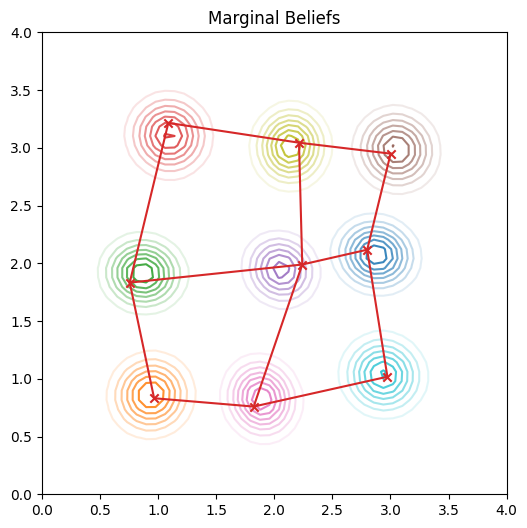

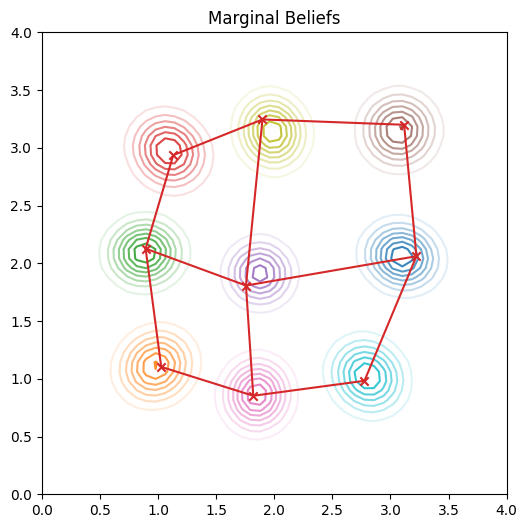

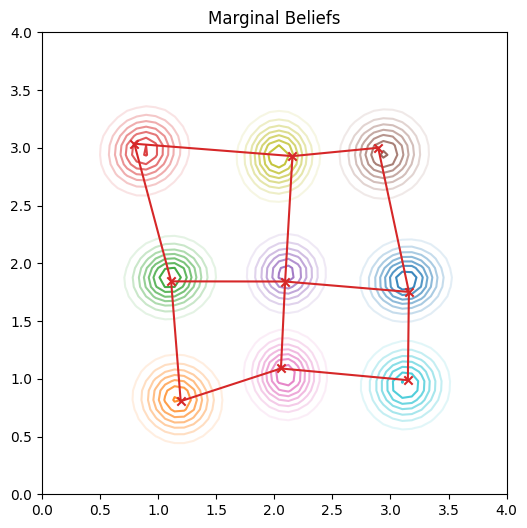

In [8]:
INIT_SIGMA = 0.1       # observed spread of particles
ITER = 10              # number of iteration to make particles converge
MSG_PASS_PER_ITER = 5  # number of message passing cycles per iteration (or number of msg passing before 1 linearization)

loopy_gabp = bp.LoopyLinearGaussianBP(node_means=init_mu, node_covars=init_covar,
                                      factor_graph=factor_graph,
                                      tensor_kwargs=tensor_kwargs)
means, covars = loopy_gabp.solve(num_iters=ITER, msg_pass_per_iter=MSG_PASS_PER_ITER)

# plot surface(s)
for d in range(batch_dim):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title("Marginal Beliefs")

    bel_distbs = [dist.Gaussian(mu, sigma, **tensor_kwargs) for mu, sigma in zip(means[d], covars[d])]
    plot_dists(ax, bel_distbs, lims=LIMS)
    plot_graph(ax, batched_node_pos[d], factor_graph)
    plt.xlim(*LIMS[:2])
    plt.ylim(*LIMS[2:])